In [62]:
import glob
import cv2
import numpy as np
import csv
import profile
import matplotlib.image as mpimg
import pickle
import xgboost
from functools import partial
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC
from pprint import pprint
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import StandardScaler
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Load and label data

In [610]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9  # HOG orientations
pixels_per_cell = 8 # HOG pixels per cell
cells_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [219]:
non_car_images = glob.glob('./non-vehicles/**/*.png', recursive=True) 
car_images = glob.glob('./vehicles/**/*.png', recursive=True)

X_car = extract_features(car_images, spatial_feat=True, hist_feat=True, color_space='HSV')
X_non_car = extract_features(non_car_images, spatial_feat=True, hist_feat=True, color_space='HSV')

X = np.vstack((X_car, X_non_car))
        
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

y_features = np.hstack((np.ones(len(X_car)), np.zeros(len(X_non_car))))

X_data, y_data = shuffle(X_scaled, y_features)

test_index = int(np.floor(0.8*len(X_data)))
print(test_index)

X_test, y_test = X_data[test_index:], y_data[test_index:]
X_train, y_train = X_data[:test_index], y_data[:test_index]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

In [ ]:
bst = xgboost.XGBClassifier(max_depth=3)
bst.fit(X_train, y_train, eval_metric='auc')
predictions = bst.predict(X_test)
acc = accuracy_score(y_test, predictions)
print('XGBoost test set accuracy: {}'.format(acc))

In [ ]:
sclf = SVC(kernel='rbf')
sclf.fit(X_train, y_train)

predictions = sclf.predict(X_test)
acc = accuracy_score(predictions, y_test)
print('SVM test set accuracy: {}'.format(acc))

In [221]:
lclf = LinearSVC()
lclf.fit(X_train, y_train)

predictions = lclf.predict(X_test)
acc = accuracy_score(predictions, y_test)
print('LinearSVC test set accuracy: {}'.format(acc))

accuracy on validation set: 0.9895833333333334


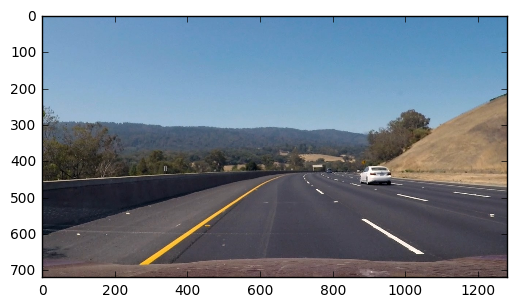

In [646]:
class CarTracker():
    def __init__(self, sample_image, classifier=None, is_video=False):
        self.sample_image = sample_image
        self.is_video = is_video
        self.clf = classifier
        self.counter = 3
        self.current_heatmap = np.zeros_like(sample_image[:,:,0]).astype(np.float32)
        
    def get_windowed_features(self, img, scale=1, spatial_size=(32,32), cells_per_step=1, pixels_per_cell=8, nbins=32, bins_range=(0, 1), color_space='HSV'): #window should be fractions of the image shape
        image_window_size = 64
        
        image = img.astype(np.float32) / np.max(img)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        image = cv2.resize(image, (np.int(image.shape[1] // scale), np.int(image.shape[0] // scale)))
        x_block_count = (image.shape[1] // pixels_per_cell) - 1
        y_block_count = (image.shape[0] // pixels_per_cell) - 1
        features_per_block = orientations * cells_per_block**2
        blocks_per_window = (image_window_size // pixels_per_cell) -1
        cells_per_step = 1
        x_step_count = (x_block_count - blocks_per_window) // cells_per_step
        y_step_count = (y_block_count - blocks_per_window) // cells_per_step
        
        ch0 = image[:,:,0]
        ch1 = image[:,:,1]
        ch2 = image[:,:,2]

        
        hog0 = get_hog_features(ch0, orientations, pixels_per_cell, cells_per_block, feature_vec=False)
        hog1 = get_hog_features(ch1, orientations, pixels_per_cell, cells_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orientations, pixels_per_cell, cells_per_block, feature_vec=False)

        features_for_window = []
        windows = []
        for x_step in range(x_step_count):
            for y_step in range(y_step_count):
                x_pos = x_step * cells_per_step
                y_pos = y_step * cells_per_step
                
                features = []

                xleft = x_pos*pixels_per_cell
                ytop = y_pos*pixels_per_cell
                
                image_tile = cv2.resize(image[ytop:ytop+image_window_size, xleft:xleft+image_window_size], (64,64))
                
                image_tile = image[y_pos*pixels_per_cell:y_pos*pixels_per_cell+image_window_size,
                                    x_pos*pixels_per_cell:x_pos*pixels_per_cell+image_window_size]
                
                features.append(cv2.resize(image_tile, spatial_size).ravel())

                features.append(np.histogram(image_tile[:,:,0], bins=nbins, range=bins_range)[0])
                features.append(np.histogram(image_tile[:,:,1], bins=nbins, range=bins_range)[0])
                features.append(np.histogram(image_tile[:,:,2], bins=nbins, range=bins_range)[0])

                hog_feat0 = hog0[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_feat1 = hog1[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_feat2 = hog2[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_features = np.concatenate((hog_feat0, hog_feat1, hog_feat2))
                
                features.append(hog_features)
                w_loc0 =(int(xleft * scale), 
                         int(ytop * scale))
                w_loc1 = (int((xleft+image_window_size) * scale), 
                          int((ytop+image_window_size) * scale))

                features_for_window.append(np.hstack(features))    
                windows.append((w_loc0, w_loc1))
                
        return features_for_window, windows
    
    def find_hit_windows(self, image, scale=1.5, y_start_stop=(0, image.shape[0]), cells_per_step=1):
        adjust_y_0 = y_start_stop[0]
        adjust_y_1 = y_start_stop[1]
        adjust_x = 700
        image = image[adjust_y_0:adjust_y_1, adjust_x:]
        hits_windows = []
        features, windows = self.get_windowed_features(image, scale, cells_per_step=cells_per_step)
        for feature, window in zip(features, windows):
            f = X_scaler.transform(np.array(feature).reshape(1, -1))
            prediction = lclf.predict(f)
            if prediction == 1:
                coords = window
                coords_adjusted = ((coords[0][0] + adjust_x, coords[0][1] + adjust_y_0), 
                                    (coords[1][0] + adjust_x, coords[1][1] + adjust_y_0)) 
                hits_windows.append(coords_adjusted)
        return hits_windows
        
    def update_heatmap(self, boxlist):
        heatmap = np.zeros_like(self.sample_image[:,:,0]).astype(np.float32)    
        alpha = 0.15
        for box in boxlist:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heatmap[heatmap < 6] = 0
        self.current_heatmap = alpha * heatmap + (1-alpha) * self.current_heatmap
        maxim = np.max(self.current_heatmap)
        self.current_heatmap[self.current_heatmap <= 1] = 0
        return self.current_heatmap

    def draw_boxes(self, image, bboxes, color=(255, 0, 255), thick=1):
        draw_img = np.copy(image)
        for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        return draw_img 
    
    def draw_labeled_boxes(self, image, heatmap):
        # from provided Udacity utility functions
        labels = label(heatmap)
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
        return image
    
    def process_frame(self, image):
        if self.is_video:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        boxes = self.find_hit_windows(image, scale=1.5, y_start_stop=(385, 550), cells_per_step=1) + \
                self.find_hit_windows(image, scale=2, y_start_stop=(500, 600), cells_per_step=2) 
            
        heatmap = tracker.update_heatmap(boxes)
        heatmap_image = self.draw_labeled_boxes(image, heatmap)
        heatmap_image = self.draw_boxes(image, boxes)
#         self.counter += 1
#         if self.is_video:
        heatmap_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return heatmap_image


# %%prun
image = cv2.imread('./test_images/test3.jpg')
tracker = CarTracker(sample_image=image, classifier=lclf)
plt.imshow(tracker.process_frame(image))

BACK TO 5 FOR THRESHOLD

In [647]:
tracker = CarTracker(image, lclf, True)
black_output = 'other_test_output.mp4'
white_output = 'other_output121.mp4'
# clip1 = VideoFileClip("./test_video.mp4")
clip1 = VideoFileClip("./project_video.mp4")
# clip1 = VideoFileClip("./beggining.mp4")
# clip1 = VideoFileClip("./MidClip.mp4")
# clip1 = VideoFileClip("./beggining.mp4")
white_clip = clip1.fl_image(tracker.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video other_output121.mp4
[MoviePy] Writing video other_output121.mp4



100%|█████████▉| 1260/1261 [03:23<00:00,  6.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: other_output121.mp4 

CPU times: user 3min 19s, sys: 3.05 s, total: 3min 22s
Wall time: 3min 23s


In [648]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
Pipeline([
            ('scaling', StandardScaler(with_mean=0, with_std=1)),
            ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
            ('classification', SVC(kernel="rbf", verbose=1, probability=True))
        ])

# Lesson utility functions

In [ ]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 1)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = cv2.imread(file)
        image = image.astype(np.float32) / np.max(image)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features



